# Code for finding the optimal (lowest loss) parameters of a coaxmon with a circular coupler for given qubit and qubit-coupler capacitances

This code allows us to find the optimal parameters {R1, R2, R3, R4} for a coaxomon with a circular coupler for specified qubit-qubit (C_qq) and qubit-coupler (C_qc) capactitances. 

R1: radius of central concuctor of qubit
R2: outer radius of gap between the central conductor of the qubit and the coupler / inner radius of coupler
R3: outer radius of coupler / inner radius of gap between the coupler and the ground
R4: total size of the qubit with coupler / outer radius of the gap between the coupler and the ground

In the code, we will use the parametrisation {r1, r2, r3, R4}. Where the small r's are the ratios of the beforementioned radii with respect to R4: r1=R1/R4, r2=R2/R4, r3=R3/R4.

The parameters are optimal in the sense that these are the ones that give the lowest total participation ratio (P) for the specified qubit-ground and qubit-coupler capactitances.

Two important **assumptions** have been made in this code:
* The capactitances C_qg and C_qc always scale linearly with the system's size R4, for any {r1, r2, r3} configuration
* The participation ratio (P) is inversely proportional to R4, for any {r1, r2, r3} configuration

Both assumptions have are based on scans over R4 values for constant {r1, r2, r3} configurations, and that for different {r1, r2, r3} configurations. C_qg seems to be almost perfectly proportional to R4, while for C_qc proportionality still seems to be a good approximation. P is not exactly inversely proportional to R4 but it seems to be a good approximation in all cases.


Using these two assumptions is important because they reduce the dimensionality of the restrained optimisation problem from 4 to 3. 

The code works as follows:

The input for the code consists of simulation data. For each value of r1, a scan was made over values of r2 and r3 (with always the restriction: r1<r2<r3). This gives matrices with values for P, C_qg and C_qc. Because both C_qg and C_qc scale linearly with R4, we only care about the ration C_qc:C_qg. Dividing the C_qc and C_qg matrices we get this ratio matrix. The next step is find for each value of r2 (so for each row of the matrix), at which value of r3 the ratio is equal to the ratio that we specified. This value of r3 is then saved in a matrix. We also look at the absolute value of one of the capacitances and compare this to the magnitude of the desired capacitance. This ratio tells us how many times bigger/smaller R4 should be taken in comparison to the R4 in the simulations (which is known and is 50 microns). This data is stored in a different matrix. Together these two types of matrices give us all the possible configurations {r1, r2, r3, R4} that have the desired capacitances C_qg and C_qc.

What we do next is check which value of P belongs to the found configurations {r1, r2, r3} (=the entrices of the matrices). This value is then divdided (because P is inversely proportional to R4) by the factor that is required to give C_qg and C_qc the correct magnitude. 

The last step is to compare these corrected values for P and find which configuration {r1, r2, r3} gives the lowes participation ratio.

An important point is that most configurations {r1, r2} (= the rows of the matrices) contains a narrow domain of ratios (as a function of all possible r3) and that there is no intersection with the desired ratio. 

The desired qubit-qubit (=C_qq) and qubit-couler (=C_qc) capacitances should be specified in the cell below.

In [1]:
C_qq_desired = 65.63     # in femto-Farad
C_qc_desired = 27   # in femto-Farad
ratio_desired = C_qc_desired/C_qq_desired

print('desired ratio: ', ratio_desired)

desired ratio:  0.41139722687795216


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import special 
from scipy.interpolate import interp1d

In [3]:
r1 = np.linspace(0.1,0.7,7)
r2 = np.linspace(0.2,0.8,7)
r3 = np.linspace(0.3,0.9,7)
R4 = np.linspace(10,100,10)
found_rmatrix = np.zeros((len(r1), len(r2)))
found_R4matrix = np.zeros((len(r1), len(r2)))
found_Pmatrix = np.zeros((len(r1), len(r2)))

C:\Users\Stef\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\Stef\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':
C:\Users\Stef\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.


found r3:  0.8029926352674124
amplification factor:  27.23799195792914
Beware! There could be a close intersection for curve with r1 =  0.2  and r2 =  0.7000000000000002
[0.41579696 0.47973861]
Beware! There could be a close intersection for curve with r1 =  0.5  and r2 =  0.8
[0.40177132]
*********************
the found P matrix is: 
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 9.93637143e-05 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0

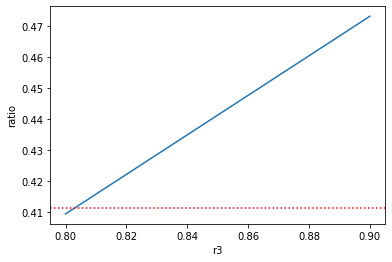

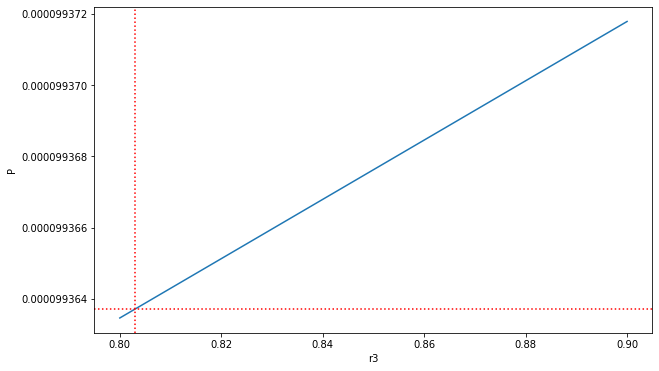

In [4]:
R4_simulation = 50 #the R4 that was used to obtain the simulation data in microns. 
                   #This is necessary to get an absolute value for R4 from the code
    
for i in range(len(r1)):
    df_P = pd.read_csv (r'C:\Users\Stef\Documents\Documenten\Master\Project Russia\Resonator design\Coaxmons\Coaxmon_coupler_optimise\P_' + str(i+1) +'.csv')
    df_QG = pd.read_csv (r'C:\Users\Stef\Documents\Documenten\Master\Project Russia\Resonator design\Coaxmons\Coaxmon_coupler_optimise\QG_' + str(i+1) +'.csv')
    df_QC = pd.read_csv (r'C:\Users\Stef\Documents\Documenten\Master\Project Russia\Resonator design\Coaxmons\Coaxmon_coupler_optimise\QC_' + str(i+1) +'.csv')
    df_P = df_P.as_matrix()
    df_QG = df_QG.as_matrix()
    df_QC = df_QC.as_matrix()
    P = df_P[0:(len(r2)-i), 1:(len(r2)-i+1)]
    C_qg = df_QG[0:(len(r2)-i), 1:(len(r2)-i+1)]
    C_qc = -1*df_QC[0:(len(r2)-i), 1:(len(r2)-i+1)]
    ratio = C_qc/C_qg
    #print('ratio van r1 = ', r1[i])
    #print(ratio)
   
    for j in range(len(r2)-i):
        arr = ratio[j,j:]
        if max(arr[np.nonzero(arr)]) < ratio_desired or min(arr[np.nonzero(arr)]) >  ratio_desired:
            if abs(ratio_desired - max(arr[np.nonzero(arr)])) < 0.005 or abs(min(arr[np.nonzero(arr)]) - ratio_desired) < 0.01:
                print('Beware! There could be a close intersection for curve with r1 = ', r1[i],' and r2 = ', r2[j+i])
                print(arr[np.nonzero(arr)])
                
                #We give a warning when the ratio domain in a matrix row ALMOST contains the desired ratio. An intersection can then
                #probably be found by simulating on a finer grid.
        else:
            found_rmatrix[i,j+i] = np.interp(ratio_desired, ratio[j,j:], r3[(j+i):])
            found_R4matrix[i,j+i] = np.interp(found_rmatrix[i,j+i], r3[(j+i):], C_qc[j,j:])/C_qc_desired
            found_Pmatrix[i,j+i] = np.interp(found_rmatrix[i,j+i], r3[(j+i):], P[j,j:])*found_R4matrix[i,j+i]
            
            print('found r3: ', found_rmatrix[i,j+i])
            print('amplification factor: ', 1/found_R4matrix[i,j+i])
            
            plt.figure()
            plt.plot(r3[(j+i):], ratio[j,j:])
            plt.xlabel('r3')
            plt.ylabel('ratio')
            plt.axhline(ratio_desired, color='r', linestyle=':')
            
            plt.figure(figsize=(10,6))
            plt.plot(r3[(j+i):],  P[j,j:]*found_R4matrix[i,j+i])
            plt.axvline(found_rmatrix[i,j+i], color='r', linestyle=':')
            plt.axhline(found_Pmatrix[i,j+i], color='r', linestyle=':')
            plt.xlabel('r3')
            plt.ylabel('P')

print('*********************')
print('the found P matrix is: ')
print(found_Pmatrix)
#print(found_Pmatrix[np.nonzero(found_Pmatrix)])
x,y = np.where( found_Pmatrix==np.min(found_Pmatrix[np.nonzero(found_Pmatrix)])) #find minimum of found_Pmatrix
print('indices of configuration with lowest P(tot): ', x,y)
index_lowestP = (x,y)
lowest_P = found_Pmatrix[index_lowestP]
#print('lowest_P: ', lowest_P)
best_r1 = r1[index_lowestP[0]]
best_r2 = r2[index_lowestP[1]]
best_r3 = found_rmatrix[index_lowestP]
best_R4 = R4_simulation/found_R4matrix[index_lowestP]
print('best values {r1, r2, r3, R4} are: ', best_r1, best_r2, best_r3, best_R4)
print('this gives values: {R1, R2, R3, R4}: ', best_r1*best_R4, best_r2*best_R4, best_r3*best_R4, best_R4, 'all in microns')

In [5]:
r1 = np.linspace(0.05,0.85,17)
r2 = np.linspace(0.1,0.9,17)
r3 = np.linspace(0.15,0.95,17)

found_rmatrix = np.zeros((len(r1), len(r2)))
found_R4matrix = np.zeros((len(r1), len(r2)))
found_Pmatrix = np.zeros((len(r1), len(r2)))

R4_simulation = 50 #the R4 that was used to obtain the simulation data. 
                   #This is necessary to get an absolute value for R4 from the code
df_P = pd.read_csv (r'C:\Users\Stef\Documents\Documenten\Master\Project Russia\Resonator design\Coaxmons\Coaxmon_coupler_optimise\P_all.csv')
df_QG = pd.read_csv (r'C:\Users\Stef\Documents\Documenten\Master\Project Russia\Resonator design\Coaxmons\Coaxmon_coupler_optimise\C_qq_all.csv')
df_QC = pd.read_csv (r'C:\Users\Stef\Documents\Documenten\Master\Project Russia\Resonator design\Coaxmons\Coaxmon_coupler_optimise\C_qc_all.csv')    
df_P = df_P.as_matrix()
df_QG = df_QG.as_matrix()
df_QC = df_QC.as_matrix()
start_index = 0
print('desired ratio: ', ratio_desired)

for i in range(len(r1)):   
    P = df_P[i:len(r2), 1+start_index:(start_index+len(r2)-i+1)]
    C_qg = df_QG[i:len(r2), 1+start_index:(start_index+len(r2)-i+1)]
    C_qc = -1*df_QC[i:len(r2), 1+start_index:(start_index+len(r2)-i+1)]
    ratio = C_qc/C_qg
    start_index = start_index + (len(r2)-i)
        
    for j in range(len(r2)-i):
        arr = ratio[j,j:]

        if max(arr[np.nonzero(arr)]) < ratio_desired or min(arr[np.nonzero(arr)]) >  ratio_desired:
            if abs(ratio_desired - max(arr[np.nonzero(arr)])) < 0.005 or abs(min(arr[np.nonzero(arr)]) - ratio_desired) < 0.01:
                print('Beware! There could be a close intersection for curve with r1 = ', r1[i],' and r2 = ', r2[j+i])
                print(arr[np.nonzero(arr)])
                
                #We give a warning when the ratio domain in a matrix row ALMOST contains the desired ratio. An intersection can then
                #probably be found by simulating on a finer grid.
        else:
            found_rmatrix[i,j+i] = np.interp(ratio_desired, arr, r3[(j+i):])
            found_R4matrix[i,j+i] = np.interp(found_rmatrix[i,j+i], r3[(j+i):], C_qc[j,j:])/C_qc_desired
            found_Pmatrix[i,j+i] = np.interp(found_rmatrix[i,j+i], r3[(j+i):], P[j,j:])*found_R4matrix[i,j+i]
            
            #print('found r3: ', found_rmatrix[i,j+i])
            #print('amplification factor: ', 1/found_R4matrix[i,j+i])
            
            #plt.figure()
            #plt.plot(r3[(j+i):], ratio[j,j:])
            #plt.xlabel('r3')
            #plt.ylabel('ratio')
            #plt.axhline(ratio_desired, color='r', linestyle=':')
            
            #plt.figure(figsize=(10,6))
            #plt.plot(r3[(j+i):],  P[j,j:]*found_R4matrix[i,j+i])
            #plt.axvline(found_rmatrix[i,j+i], color='r', linestyle=':')
            #plt.axhline(found_Pmatrix[i,j+i], color='r', linestyle=':')
            #plt.xlabel('r3')
            #plt.ylabel('P')


#find minimum of found_Pmatrix
print('*********************')
#print('the found P matrix is: ')
#print(found_Pmatrix)
#print(found_Pmatrix[np.nonzero(found_Pmatrix)])
x,y = np.where(found_Pmatrix==np.min(found_Pmatrix[np.nonzero(found_Pmatrix)]))
print('indices of configuration with lowest P(tot): ', x,y)
index_lowestP = (x,y)
lowest_P = found_Pmatrix[index_lowestP]
print('lowest_P: ', lowest_P)
best_r1 = r1[index_lowestP[0]]
best_r2 = r2[index_lowestP[1]]
best_r3 = found_rmatrix[index_lowestP]
best_R4 = R4_simulation/found_R4matrix[index_lowestP]
print('best values {r1, r2, r3, R4} are: ', best_r1, best_r2, best_r3, best_R4)
print('this gives values: {R1, R2, R3, R4}: ', best_r1*best_R4, best_r2*best_R4, best_r3*best_R4, best_R4, 'all in microns')

desired ratio:  0.41139722687795216
Beware! There could be a close intersection for curve with r1 =  0.05  and r2 =  0.55
[0.41722144 0.47777761 0.51797411 0.54815216 0.57209858 0.59170951
 0.6080909  0.62192672]
Beware! There could be a close intersection for curve with r1 =  0.1  and r2 =  0.55
[0.41954921 0.4804897  0.52054656 0.55072376 0.57464123 0.59421944
 0.61056226 0.62436634]
Beware! There could be a close intersection for curve with r1 =  0.25  and r2 =  0.6
[0.41334751 0.47295436 0.51227338 0.54166646 0.56490338 0.58381823
 0.59955934]
Beware! There could be a close intersection for curve with r1 =  0.35  and r2 =  0.8
[0.3245651  0.37557707 0.40950099]
Beware! There could be a close intersection for curve with r1 =  0.39999999999999997  and r2 =  0.65
[0.41795024 0.47725755 0.51588383 0.54447101 0.56711373 0.58498802]
Beware! There could be a close intersection for curve with r1 =  0.49999999999999994  and r2 =  0.7000000000000001
[0.41687475 0.47557729 0.51340957 0.541176

C:\Users\Stef\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\Stef\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
C:\Users\Stef\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


The sorted solutions {r1, r2, r3, R4, P(tot)} are:
[[   0.05       0.6        0.66272 2806.05908    0.00009]
 [   0.05       0.65       0.73158 2811.5647     0.00009]
 [   0.05       0.7        0.80316 2816.46038    0.00009]
 [   0.05       0.75       0.89038 2821.17637    0.00009]
 [   0.1        0.6        0.66103 1351.32538    0.0001 ]
 [   0.1        0.65       0.73022 1356.89781    0.0001 ]
 [   0.1        0.7        0.80262 1361.8948     0.0001 ]
 [   0.1        0.75       0.8889  1366.58654    0.0001 ]
 [   0.15       0.75       0.88565  883.7065     0.00011]
 [   0.15       0.7        0.79903  878.9585     0.00011]
 [   0.15       0.6        0.65817  868.23265    0.00011]
 [   0.15       0.65       0.72774  873.90093    0.00011]
 [   0.2        0.6        0.65399  626.61844    0.00012]
 [   0.2        0.65       0.72402  632.42617    0.00012]
 [   0.2        0.7        0.79597  637.58929    0.00012]
 [   0.2        0.75       0.88086  642.40461    0.00012]
 [   0.25       0.65 

C:\Users\Stef\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


Text(0, 0.5, 'P(tot)')

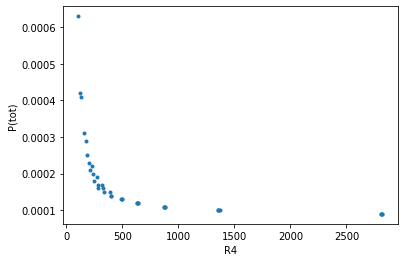

In [6]:
#variation of the script where we also specify R4 which then needs to be satisfied approximately
R4_desired = 100
#R4_final = 1/found_R4matrix[np.nonzero(found_R4matrix)]*R4_simulation
R4_final = 1/found_R4matrix*R4_simulation
num_solutions = len(found_R4matrix[np.nonzero(found_R4matrix)])
R4_diff = abs(R4_final-R4_desired)

solutions_coords = []
solutions = np.zeros((num_solutions, 5))
for i in range (num_solutions):
    solutions_coords.append(np.where(found_R4matrix == found_R4matrix[np.nonzero(found_R4matrix)][i]))
    solutions[i,0] = r1[solutions_coords[i][0]]
    solutions[i,1] = r2[solutions_coords[i][1]]
    solutions[i,2] = found_rmatrix[solutions_coords[i]]
    solutions[i,3] = R4_final[solutions_coords[i]]
    solutions[i,4] = found_Pmatrix[solutions_coords[i]]
rounded_solutions = np.around(solutions, decimals=5)
np.set_printoptions(suppress=True)
#print('the solutions {r1, r2, r3, R4, P(tot)} are: ')
#print(rounded_solutions)
print('The sorted solutions {r1, r2, r3, R4, P(tot)} are:')
print(rounded_solutions[np.argsort(rounded_solutions[:, 4])])

plt.plot(rounded_solutions[:,3], rounded_solutions[:,4], '.')
plt.xlabel('R4')
plt.ylabel('P(tot)')